# Redes genéticas continuas // Activador-Inhibidor

En este _Notebook_ utilizaremos Python para resolver numéricamente un modelo determinista y continuo de una red genética de dos genes conocida como **Activador-Inhibidor**. Para profundizar en el análisis matemático de la dinámica del sistema, así como en la discusión de distintos enfoques de modelación de redes genéticas, les recomiendo [estas notas](https://hal.archives-ouvertes.fr/hal-00554639/document).

Lo primero que tenemos que hacer es importar la librería de cómputo científico y análisis numérico de Python (NumPy), el _solver_ de ecuaciones diferenciales (odeint) y la librería de graficación (matplotlib).

In [3]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# This makes the plots appear inside the notebook
%matplotlib inline

## Modelo dinámico de regulación genética

Un represilador son tres inhibidores...

Vamos a representar a la variable de estado al tiempo $t$ mediante el vector $x(t)=(r_a, r_b, p_a, p_b)$ (este vector representa al estado), donde $r_a$ y $r_b$ denotan las concentraciones de mRNA asociados a los genes $A$ y $B$, mientras que $p_a$ y $p_b$ las concentraciones de proteínas traducidas de los correspondientes mRNAs.

Ahora, vamos a denotar con las constantes $\delta_a$ y $\delta_b$ la tasa de degradación de las proteínas A y B, respectivamente, mientras que la tasa de degradación de mRNAs se denotará con $\gamma_a$ y $\gamma_b$.  

Para modelar la traducción, vamos a asumir que es un proceso que depende linealmente de la concentración del correspondiente mRNA, multiplicado por una constante, $k_a$ y $k_b$ respectivamente, que representa la tasa de traducción de cada proteína.   

Por otro lado, en general la transcripción se modela a partir de la suma (o productos) de las concentraciones de los factores de transcripción (proteínas) que modulan, ya sea positiva o negativamente, la expresión del gen en cuestión.  En particular, vamos a considerar que una interacción de activación (representada en una red genética como $A  \rightarrow B$) se describe por una función monótonamente creciente y no-lineal con rango en el intervalo $[0,1]$.  La función de Hill cumple con estas características:

$$
h^+(p; \theta, n)= \frac{p^n}{\theta^n+p^n},
$$

donde $\theta$ denota el umbral de expresión y a $n$ se les conoce como el coeficiente de Hill. 

Análogamente, para modelar una interacción de inhibición (representada en una red genética como $A \dashv B$) podemos usar la siguiente función:

$$
h^-(p; \theta, n)=1-h^+=\frac{\theta^n}{p^n+\theta^n}
$$

Como el rango de estas funciones es el intervalo $[0,1]$, las multiplicaremos por una constante que representa la tasa máxima de transcripción. En el caso de la red Activador-Inhibidor anteriormente descrita, consideraremos $m_a$ para el gen $A$ y $m_b$ para el gen $B$, así como $\theta_a$, $\theta_b$ y $n_a$, $n_b$ para los coeficientes de Hill respectivos.

Entonces la dinámica del sistema, $\frac{dx}{dt}=F(x(t))$, está dada por el siguiente sistema de ecuaciones diferenciales:

1)cambio en mRNA de a: Tasa máx de trsnc. por activación menos tasa de degradación.
2)cambio en mrNA de B: B está inhibido por A
3)Cambio de proteína en A: tasa de trad. x conc. de mRNA de A menos degradación de prot y RNA de A
4) Igual pero para b


$$
\frac{d r_a}{dt}= m_a \, h^+(p_b; \theta_b, n_b) - \gamma_a \, r_a \\     
\frac{d r_b}{dt}= m_b \, h^-(p_a; \theta_a, n_a) - \gamma_b \, r_b \\
\frac{d p_a}{dt}= k_a \, r_a - \delta_a \, p_a \\
\frac{d p_b}{dt}= k_b \, r_b - \delta_b \, p_b 
$$

con condiciones iniciales $x(0)=(r_a^0, r_b^0, p_a^0, p_b^0)$.



##  Soluciones numéricas

Para resolver numéricamente el sistema de ecuaciones diferenciales, vamos a definir las funciones descritas anteriormente:

In [208]:
#System of differential equations (Activator-Inhibitor)
#aqui ya le moviste todo para que tenga 3
def F(x, t, params_a, params_b, params_c):
    
    ra, rb, rc, pa, pb, pc = x;

    dradt = params_a['m']*hillI(pc, params_c['theta'], params_c['n']) - params_a['gamma']*ra;                    
    drbdt = params_b['m']*hillI(pa, params_a['theta'], params_a['n']) - params_b['gamma']*rb;
    drcdt = params_c['m']*hillI(pb, params_b['theta'], params_b['n']) - params_c['gamma']*rc;
    
    
    #dradt=params_a['m']/(1+ (pc0/params_a['k'])**params_a['n']     )
    
    dpadt = params_a['k']*ra - params_a['delta']*pa;                    
    dpbdt = params_b['k']*rb - params_b['delta']*pb;
    dpcdt= params_c['k']*rc - params_c['delta']*pc;
    
    return [dradt, drbdt, drcdt, dpadt, dpbdt, dpcdt]

#Hill function (inhibition)
def hillI(p, theta, n):
    return (1-((p**n)/(p**n + theta**n)))
    
#Hill function (activation)    
def hillA(p, theta, n):
    return (p**n)/(p**n + theta**n)

Posteriormente vamos a definir los parámetros de la simulación:

In [209]:
T=100.   #Time of integration
nT=1000  #Number of integration steps

#Parameters (Gene A)
m_a=1.8       #maximal transcription rate 
theta_a=.6542; #Hill parameter 
n_a=3.          #Hill coefficient
gamma_a=1.      #mRNA degradation rate
delta_a=1.      #Protein degradation rate
k_a=1.          #translation rate

#Parameters (Gene B)
m_b=1.8        #maximal transcription rate 
theta_b=.6542; #Hill parameter 
n_b=3.          #Hill coefficient
gamma_b=1.      #mRNA degradation rate
delta_b=1.      #Protein degradation rate
k_b=1.          #translation rate

# Ps añadámosle el de C :v
m_c=1.8        #maximal transcription rate 
theta_c=.6542; #Hill parameter 
n_c=3.          #Hill coefficient
gamma_c=1.      #mRNA degradation rate
delta_c=1.      #Protein degradation rate
k_c=1.          #translation rate

#Initial conditions
ra0=1.
rb0=1.
rc0=1.
pa0=1.
pb0=1.
pc0=1.

Ahora sí, procedemos a resolver el sistema de ecuaciones para los parámetros y condiciones iniciales especificados anteriormente

In [210]:

params_a={'m':m_a, 'theta':theta_a, 'n':n_a, 'gamma':gamma_a, 'delta':delta_a,'k':k_a}
params_b={'m':m_b, 'theta':theta_b, 'n':n_b, 'gamma':gamma_b, 'delta':delta_b,'k':k_b}
params_c={'m':m_c, 'theta':theta_c, 'n':n_c, 'gamma':gamma_c, 'delta':delta_c,'k':k_c}

t = np.linspace(0,T,nT)     
x0 = [ra0, rb0, rc0, pa0, pb0, pc0]    

xt = odeint(F, x0, t, args=(params_a, params_b, params_c))

Para visualizar los resultados obtenidos podemos graficar las variables de estado en función del tiempo

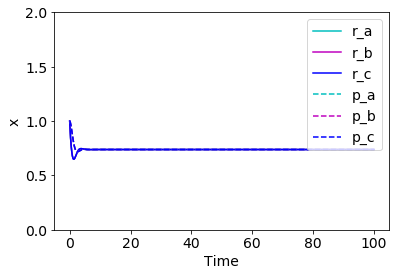

In [211]:
plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("Time")
plt.ylabel("x")
plt.plot(t, [row[0] for row in xt], label='r_a', color='c');
plt.plot(t, [row[1] for row in xt], label='r_b', color='m');
plt.plot(t, [row[2] for row in xt], label='r_c', color='b');
plt.plot(t, [row[3] for row in xt],'--', label='p_a', color='c');
plt.plot(t, [row[4] for row in xt],'--', label='p_b', color='m');
plt.plot(t, [row[5] for row in xt],'--', label='p_c', color='b');
plt.ylim([0,2])
plt.legend(loc='upper right')

También podemos visualizar los resultados mediante un plano fase:

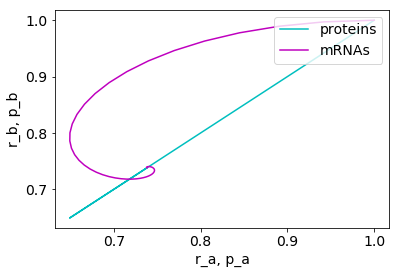

In [212]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_b, p_b")
#plt.ylabel("r_c, p_c")

plt.plot([row[0] for row in xt],[row[1] for row in xt], label='proteins', color='c');
plt.plot([row[2] for row in xt],[row[3] for row in xt], label='mRNAs', color='m');

plt.legend(loc='upper right')

In [206]:
xt

array([[1.        , 1.        , 1.        , 1.01      , 0.9       ,
        1.        ],
       [0.94232315, 0.94151065, 0.95187775, 1.00620712, 0.90664399,
        0.99763789],
       [0.89054348, 0.88914302, 0.90793897, 0.99756876, 0.90738155,
        0.99111729],
       ...,
       [0.30027401, 1.58906591, 0.49829916, 0.24715491, 1.32537624,
        0.88085914],
       [0.32390175, 1.60007859, 0.46876093, 0.25333759, 1.35104082,
        0.84297307],
       [0.35024128, 1.60929346, 0.44116715, 0.26131259, 1.37522315,
        0.80597697]])

En este caso, las espirales en el plano fase indican que la dinámica del sistema presenta oscilaciones que disminuyen en amplitud hasta converger a un atractor.

Interesantemente, perturbaciones en algunos parámetros producen un cambio en la dinámica del sistema.  Por ejemplo, si modificamos los valores en la tasa máxima de transcripción y el umbral de saturación, el sistema puede converger a un ciclo límite y exhibir oscilaciones estables. A esta transición entre un atractor estable y un oscilador períodico se le conoce como una [bifuración de Hopf](http://people.uleth.ca/~roussel/nld/intro_bifurc.pdf).


En este caso, debemos hacer pequeñas modificaciones a las condiciones para notar cambios...

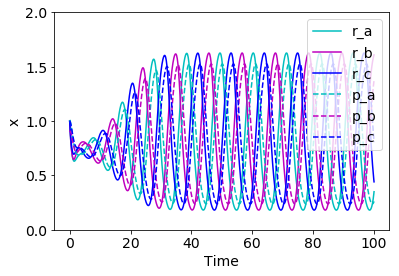

In [198]:
#Initial conditions
pa0=1.01
pb0=0.9
pc0=1.

x0 = [ra0, rb0, rc0, pa0, pb0, pc0]    
xt = odeint(F, x0, t, args=(params_a, params_b, params_c))





plt.rcParams.update({'font.size': 14})  # increase the font size
plt.xlabel("Time")
plt.ylabel("x")
plt.plot(t, [row[0] for row in xt], label='r_a', color='c');
plt.plot(t, [row[1] for row in xt], label='r_b', color='m');
#plt.plot(t, [row[2] for row in xt], label='r_c', color='b');
plt.plot(t, [row[3] for row in xt],'--', label='p_a', color='c');
plt.plot(t, [row[4] for row in xt],'--', label='p_b', color='m');
#plt.plot(t, [row[5] for row in xt],'--', label='p_c', color='b');
plt.ylim([0,2])
plt.legend(loc='upper right')



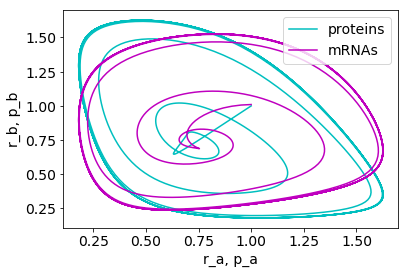

In [199]:
plt.xlabel("r_a, p_a")
plt.ylabel("r_b, p_b")

plt.plot([row[0] for row in xt],[row[1] for row in xt], label='proteins', color='c');
plt.plot([row[2] for row in xt],[row[3] for row in xt], label='mRNAs', color='m');
xt
plt.legend(loc='upper right')